In [1]:
#
# Please execute on QITE_experiments branch from GitHub
# 

from qrisp import QuantumVariable, h, x, prepare, conjugate, QPE
from qrisp.vqe.problems.heisenberg import create_heisenberg_init_function, heisenberg_problem, create_heisenberg_hamiltonian
import networkx as nx
import numpy as np
import scipy
import matplotlib.pyplot as plt
from qrisp.qite import QITE
from qrisp import QuantumVariable

import numpy as np
import sympy as sp
import time

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

def get_statevector(qc,n,subs_dic=None):
    if subs_dic is not None:
        bqc = qc.bind_parameters(subs_dic) 
    else:
        bqc = qc
    
    for i in range(bqc.num_qubits() - n):
        bqc.qubits.insert(0, bqc.qubits.pop(-1))

    statevector = bqc.statevector_array()[:2**n]
    statevector = statevector/np.linalg.norm(statevector)

    return statevector

def compute_moments(psi, H):
    E = (psi.conj().T @ H.dot(psi)).real
    S = (psi.conj().T @ (H @ H).dot(psi)).real
    return E, S, S - E**2

from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import svds
from qrisp.operators import X, Y, Z

def rescaled_Hamiltonian(L):

    # Create a graph
    G = nx.Graph()
    G.add_edges_from([(k,k+1) for k in range(L-1)]) 

    def create_heisenberg_hamiltonian(G):
        H = sum(X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) for (i,j) in G.edges())
        return H

    H = create_heisenberg_hamiltonian(G)

    M = H.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=1, which='SA')
    E0 = eigenvalues[0]

    # Rescale to E0=0
    H2 = H - E0

    M = H2.to_sparse_matrix()
    u, s, vt = svds(M, k=1, which='LM')
    spectral_norm = s[0]

    E_max = spectral_norm

    # Rescale such that spectrum in [0,1)
    H3 = H2*(1/(E_max+1))

    M = H3.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')

    # Ground state
    psi_0 = eigenvectors[:,0]

    E0 = eigenvalues[0]
    E1 = eigenvalues[1]

    delta = E1-E0
    print('Spectral gap:', delta)
    print('Ground state energy:', E0)

    return H3, psi_0


In [2]:
L = 20
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 
# nx.draw(G, with_labels=True)

In [3]:
from qrisp.operators import X, Y, Z

J = 1
B = 0
H = create_heisenberg_hamiltonian(G, J, B)
print(H)

# Define scaling factor
F = 10

# Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps
def exp_H(qv, t):
    H.trotterization(method='commuting')(qv,t/F,5)

# Hamiltonian simulation via second order Suzuki-Trotter formula with 1 step
def exp_H_2(qv, t):
    H.trotterization(order=2,method='commuting')(qv,t/F,1)

X(0)*X(1) + X(1)*X(2) + X(10)*X(11) + X(11)*X(12) + X(12)*X(13) + X(13)*X(14) + X(14)*X(15) + X(15)*X(16) + X(16)*X(17) + X(17)*X(18) + X(18)*X(19) + X(2)*X(3) + X(3)*X(4) + X(4)*X(5) + X(5)*X(6) + X(6)*X(7) + X(7)*X(8) + X(8)*X(9) + X(9)*X(10) + Y(0)*Y(1) + Y(1)*Y(2) + Y(10)*Y(11) + Y(11)*Y(12) + Y(12)*Y(13) + Y(13)*Y(14) + Y(14)*Y(15) + Y(15)*Y(16) + Y(16)*Y(17) + Y(17)*Y(18) + Y(18)*Y(19) + Y(2)*Y(3) + Y(3)*Y(4) + Y(4)*Y(5) + Y(5)*Y(6) + Y(6)*Y(7) + Y(7)*Y(8) + Y(8)*Y(9) + Y(9)*Y(10) + Z(0)*Z(1) + Z(1)*Z(2) + Z(10)*Z(11) + Z(11)*Z(12) + Z(12)*Z(13) + Z(13)*Z(14) + Z(14)*Z(15) + Z(15)*Z(16) + Z(16)*Z(17) + Z(17)*Z(18) + Z(18)*Z(19) + Z(2)*Z(3) + Z(3)*Z(4) + Z(4)*Z(5) + Z(5)*Z(6) + Z(6)*Z(7) + Z(7)*Z(8) + Z(8)*Z(9) + Z(9)*Z(10)


## QITE with singlet + QPE

In [4]:
# Tensor product of singlet states
M = nx.maximal_matching(G)
U_0 = create_heisenberg_init_function(M)

results = []

steps = 2

s_values = np.linspace(.01,1.5,20)
theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = []

H_matrix = H.to_sparse_matrix()

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k)
    qc = qv.qs.compile()

    energies = [compute_moments(get_statevector(qc,L,subs_dic={theta:s_}),H_matrix)[0] for s_ in s_values]

    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])


In [5]:
# QITE initial state
def U_QITE(qv):
    QITE(qv, U_0, exp_H_2, optimal_s[:2], 2)

In [6]:
H_rescaled, psi_0 = rescaled_Hamiltonian(20)

Spectral gap: 0.013162432840221918
Ground state energy: 1.4226555004110334e-15


In [7]:
def prepare_ground_state(precision, steps, H, U_0, psi_0):

    result = dict()

    qv = QuantumVariable(G.number_of_nodes())
    U_0(qv)

    # Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps 
    # Note: 5 steps are insufficient to obtain the ground state energy within error 0.1 (10 steps are sufficent)
    exp_H = H.trotterization(order=2,forward_evolution=False)

    qpe_res = QPE(qv,exp_H,precision=precision,kwargs={"t":2*np.pi,"steps":steps},iter_spec=True)

    qc = qpe_res.qs.compile()
    tqc = qc.transpile(basis_gates=["cz","u"])

    result["ops"] = tqc.count_ops()
    result["depth"] = tqc.depth()

    results = qpe_res.get_measurement(precompiled_qc=qc)
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
    #print(sorted_results)
    P0 = sorted_results[0]
    #print('Success probability:', P0)
    result["P0"] = P0

    #qc = qpe_res.qs.compile()

    n = H.find_minimal_qubit_amount()

    for i in range(qc.num_qubits() - n):
        qc.qubits.insert(0, qc.qubits.pop(-1))

    phi = qc.statevector_array()[:2**n]
    phi = phi/np.linalg.norm(phi)

    F0 = (np.abs(np.dot(phi.conj().transpose(),psi_0))**2)
    #print('Fidelity:', F0)
    result["F0"] = F0

    return result



In [8]:
results = dict()

for precision in range(1,6):
    result = prepare_ground_state(precision, steps, H_rescaled, U_QITE, psi_0)
    results[precision] = result

In [9]:
# Save benchmark data
current_datetime = datetime.now()
date_time_string = current_datetime.strftime("%m-%d-%H")
save_data(results,'data_PRL/QITE_QPE_L='+str(L)+'_'+date_time_string)

In [10]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(16)

In [13]:
benchmark_results = load_data('data_PRL/benchmarks_QPE_Singlet04-25-14')
results = load_data('data_PRL/QITE_QPE_L=20_04-25-23')

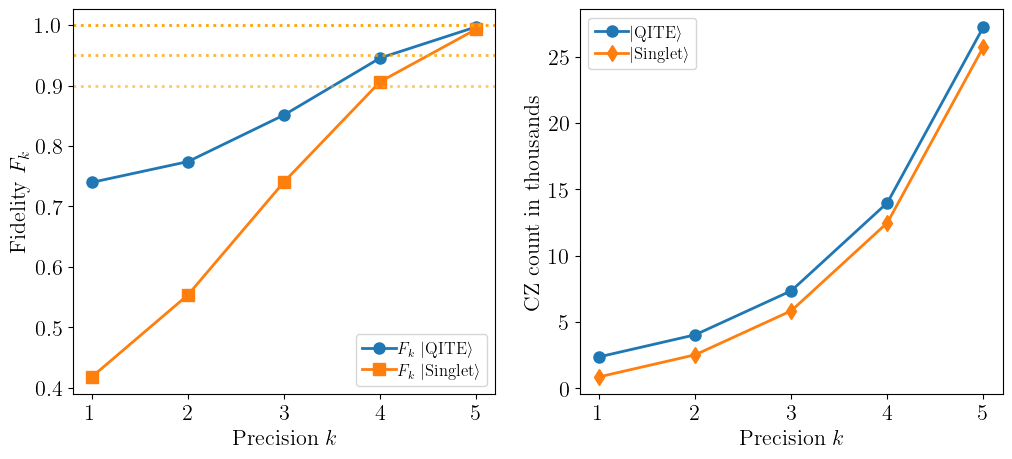

In [40]:
import matplotlib.pyplot as plt

steps = list(range(1,6))

fig, ((axF, axCZ)) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [1,1]})

###############################################################################
# SUBPLOT 1: Fidelity
###############################################################################

fidelities = [results[k]['F0'] for k in steps]
axF.plot(steps, fidelities, marker='o', label=r"$F_k\ |$QITE$\rangle$")

fidelities = [benchmark_results[20][k]['F0'] for k in steps]
axF.plot(steps, fidelities, marker='s', label=r"$F_k\ |$Singlet$\rangle$")

axF.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
axF.axhline(y=0.95, color="orange", linestyle=':', alpha=0.8)
axF.axhline(y=0.9, color="orange", linestyle=':', alpha=0.6)

axF.legend(loc="best", fontsize=12)
axF.set_xlabel(r"Precision $k$")
axF.set_ylabel(r"Fidelity $F_k$")

#axP = axF.twinx()

#probabilities = [results[k]['P0'] for k in steps]
#axP.plot(steps, fidelities, marker='o', label=r'P_k')

#probabilities = [benchmark_results[20][k]['P0'] for k in steps]
#axP.plot(steps, fidelities, marker='s', label=r'P_k')

#axP.set_ylabel(r"Probability$")

###############################################################################
# SUBPLOT 2: Gate counts
###############################################################################

cz = [results[k]['ops']['cz']/1000 for k in steps]
axCZ.plot(steps, cz, marker='o', label=r"$|$QITE$\rangle$")

cz = [benchmark_results[L][k]['ops']['cz']/1000 for k in steps]
axCZ.plot(steps, cz, marker='d', label=r"$|$Singlet$\rangle$")

axCZ.legend(loc="best", fontsize=12)
axCZ.set_xlabel(r"Precision $k$")
axCZ.set_ylabel(r"CZ count in thousands")

#plt.tight_layout()
#plt.savefig("plots_PRL/QITE_QPE_L="+str(L)+".pdf")
plt.show()